## 1. Business Problem

* Calculate  claims reserve for multiple lines of business.Motor Insurance, Fire Insurance and Micro Insurance

## 2. Data Pre-processing

In [131]:
#2.1. Load required libraries
import chainladder as cl
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

#Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

#Global change of number formats by adding a comma and keeping it to two d.p.
pd.options.display.float_format = '{:,.0f}'.format

In [150]:
#2.2. Load and clean data for analysis
df = pd.read_excel('claims_data.xlsx')
df.head()

,Loss Year,Calendar Year,Paid Amount,Line of Business
0,2018,2018,42977,Motor Insurance
1,2018,2019,18689,Motor Insurance
2,2018,2020,5005,Motor Insurance
3,2018,2021,924,Motor Insurance
4,2019,2019,53141,Motor Insurance


In [151]:
#2.3 browse through the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Loss Year         30 non-null     int64 
 1   Calendar Year     30 non-null     int64 
 2   Paid Amount       30 non-null     int64 
 3   Line of Business  30 non-null     object
dtypes: int64(3), object(1)
memory usage: 1.1+ KB


In [152]:
df.describe()

,Loss Year,Calendar Year,Paid Amount
count,30,30,30
mean,"2,019","2,020","31,800"
std,1,1,"24,635"
min,"2,018","2,018",924
25%,"2,018","2,019","10,150"
50%,"2,019","2,020","30,283"
75%,"2,020","2,021","52,398"
max,"2,021","2,021","79,464"


## 3. Feature Engineering

In [153]:
#3.1. Create triangle object that stores incremental triangles by line of business
triangle_df = cl.Triangle(
    df,
    origin = 'Loss Year',
    development = 'Calendar Year',
    columns = ['Paid Amount'],
    index = ['Line of Business']
)

triangle_df

,Triangle Summary
Valuation:,2021-12
Grain:,OYDY
Shape:,"(3, 1, 4, 4)"
Index:,[Line of Business]
Columns:,[Paid Amount]


In [154]:
#3.2. Visualize the incremntal triangles 

#We shall use LoB and keys throught the rest of these tutorial.
LoB = list(df['Line of Business'].unique())
keys = LoB

incremental_triangle_df = {}

for lob in LoB:
    incremental_triangle_df[lob] = triangle_df[triangle_df['Line of Business'].isin([lob])]
    print( lob +' incremental paid loss triangle:')
    display(incremental_triangle_df[lob])

Motor Insurance incremental paid loss triangle:


,12,24,36,48
2018,"42,977","18,689","5,005",924
2019,"53,141","27,368","1,661",
2020,"66,462","24,640",,
2021,"77,671",,,


Fire Insurance incremental paid loss triangle:


,12,24,36,48
2018,"51,227","37,840","10,241","6,292"
2019,"66,979","58,025","15,191",
2020,"61,853","52,789",,
2021,"79,464",,,


Micro Insurance incremental paid loss triangle:


,12,24,36,48
2018,"33,198","10,120","3,014","2,222"
2019,"33,924","14,168","17,578",
2020,"38,104","4,224",,
2021,"39,006",,,


In [7]:
#3.3. Construct the cumulative development triangles using incr_to_cum()

cumulative_triangle_df = {}
keys = LoB
for lob in LoB:
    cumulative_triangle_df[lob] = incremental_triangle_df[lob].incr_to_cum()
    print( lob +' cumulative paid loss triangle:')
    display(cumulative_triangle_df[lob])

Motor Insurance cumulative paid loss triangle:


,12,24,36,48
2018,"42,977","61,666","66,671","67,595"
2019,"53,141","80,509","82,170",
2020,"66,462","91,102",,
2021,"77,671",,,


Fire Insurance cumulative paid loss triangle:


,12,24,36,48
2018,"51,227","89,067","99,308","105,600"
2019,"66,979","125,004","140,195",
2020,"61,853","114,642",,
2021,"79,464",,,


Micro Insurance cumulative paid loss triangle:


,12,24,36,48
2018,"33,198","43,318","46,332","48,554"
2019,"33,924","48,092","65,670",
2020,"38,104","42,328",,
2021,"39,006",,,


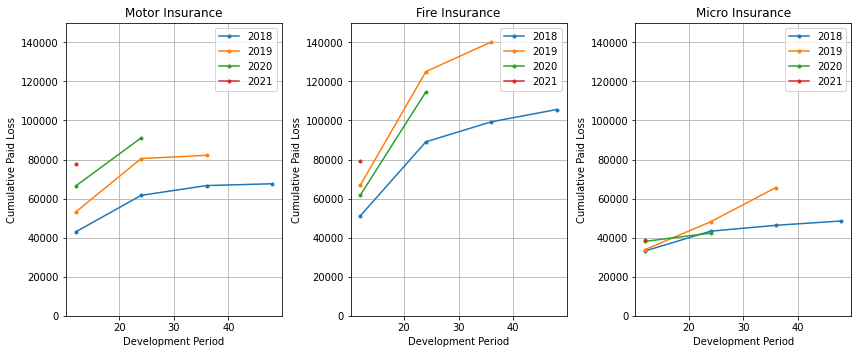

In [8]:
#3.4. Plot cumulative paid claims triangles

fig, (ax1,ax2,ax3) = plt.subplots(1, 3,figsize=(12, 5))


ax1.plot(cumulative_triangle_df['Motor Insurance'].T,marker='.')
ax1.set_title('Motor Insurance')
ax1.set_ylabel('Cumulative Paid Loss')
ax1.set_xlabel('Development Period')
ax1.set_ylim(0, 150000)
ax1.legend(cumulative_triangle_df['Motor Insurance'].T.columns)
ax1.grid()


ax2.set_title('Fire Insurance')
ax2.plot(cumulative_triangle_df['Fire Insurance'].T,marker='.')
ax2.set_ylabel('Cumulative Paid Loss')
ax2.set_xlabel('Development Period')
ax2.set_ylim(0, 150000)
ax2.legend(cumulative_triangle_df['Fire Insurance'].T.columns)
ax2.grid()


ax3.set_title('Micro Insurance')
ax3.plot(cumulative_triangle_df['Micro Insurance'].T,marker='.')
ax3.set_ylabel('Cumulative Paid Loss')
ax3.set_xlabel('Development Period')
ax3.set_ylim(0, 150000)
ax3.legend(cumulative_triangle_df['Micro Insurance'].T.columns)
ax3.grid()


plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

In [155]:
#3.5 Explore the Link ratios before adjusment of development factors
for lob in LoB:
    print( lob +' age-to-age factors:')
    display(cumulative_triangle_df[lob].link_ratio.heatmap(cmap='Reds'))

Motor Insurance age-to-age factors:


,12-24,24-36,36-48
2018,1.4349,1.0812,1.0139
2019,1.5150,1.0206,
2020,1.3707,,


Fire Insurance age-to-age factors:


,12-24,24-36,36-48
2018,1.7387,1.1150,1.0634
2019,1.8663,1.1215,
2020,1.8535,,


Micro Insurance age-to-age factors:


,12-24,24-36,36-48
2018,1.3048,1.0696,1.0480
2019,1.4176,1.3655,
2020,1.1109,,


## 4. Actuarial Modeling

In [157]:
#4.1. Peform an indepenence test as a suitable check for using the chainladder method
# The multiplicative chainladder method is based on the strong assumptions of independence across origin years and across valuation years. Mack developed tests to verify if these assumptions hol
# False indicates that correlation between years is not sufficiently large.

#Mack's test for the calendar year effect
for lob in LoB:
    print( lob +' calendar year effect test:')
    display(cumulative_triangle_df[lob].valuation_correlation(0.05).z_critical)

#Mack's test for correlations between subsequent development factors
for lob in LoB:
    print( lob +' development factors test:')
    display(cumulative_triangle_df[lob].development_correlation(0.05).t_critical)

Motor Insurance calendar year effect test:


,2019,2020,2021
2018,False,False,False


Fire Insurance calendar year effect test:


,2019,2020,2021
2018,False,False,False


Micro Insurance calendar year effect test:


,2019,2020,2021
2018,False,False,False


Motor Insurance development factors test:


,Paid Amount
LoB,
Motor Insurance,False


Fire Insurance development factors test:


,Paid Amount
LoB,
Fire Insurance,False


Micro Insurance development factors test:


,Paid Amount
LoB,
Micro Insurance,False


In [161]:
#4.2. Apply the basic chain-ladder algorithim to predict claims reserves
cum_tri_df= {}
ult_df = {}
ibnr_df = {}
cum_ult_df = {}
combined_df = {}

for lob in LoB:
    print(lob + ' losses: ')  
    cum_tri_df[lob] = incremental_triangle_df[lob].incr_to_cum().to_frame()
    ult_df[lob] = cl.Chainladder().fit(cumulative_triangle_df[lob]).ultimate_.to_frame()
    ibnr_df[lob] = cl.Chainladder().fit(cumulative_triangle_df[lob]).ibnr_.to_frame()
    cum_ult_df[lob] = pd.merge(cumulative_tri_df[lob],ult_df[lob], how= 'left',on=[cum_tri_df[lob].index, ult_df[lob].index])
    cum_ult_df[lob].drop('key_1',axis=1,inplace=True)
    cum_ult_df[lob].rename(columns={'key_0':'Loss Year','2261':'Ultimate Losses'}, inplace=True)
    combined_df[lob] = pd.merge(cum_ult_df[lob],ibnr_df[lob],how='left', on=[cum_ult_df[lob]['Loss Year'],ibnr_df[lob].index])
    combined_df[lob].drop('key_0',axis=1,inplace=True)
    combined_df[lob].drop('key_1',axis=1,inplace=True)
    combined_df[lob].rename(columns={'2261':'Claims Reserve'}, inplace=True)
    combined_df[lob].set_index('Loss Year',inplace=True)
    combined_df[lob].loc["Total"] = combined_df[lob].loc[:,['Ultimate Losses','Claims Reserve']].sum()
    display(combined_df[lob].replace(np.nan, ""))

Motor Insurance losses: 


,12,24,36,48,Ultimate Losses,Claims Reserve
Loss Year,,,,,,
2018,"42,977","61,666","66,671","67,595","67,595",
2019,"53,141","80,509","82,170",,"83,309","1,139"
2020,"66,462","91,102",,,"96,695","5,593"
2021,"77,671",,,,"118,288","40,617"
Total,,,,,"365,887","47,349"


Fire Insurance losses: 


,12,24,36,48,Ultimate Losses,Claims Reserve
Loss Year,,,,,,
2018,"51,227","89,067","99,308","105,600","105,600",
2019,"66,979","125,004","140,195",,"149,078","8,883"
2020,"61,853","114,642",,,"136,388","21,746"
2021,"79,464",,,,"172,586","93,122"
Total,,,,,"563,652","123,751"


Micro Insurance losses: 


,12,24,36,48,Ultimate Losses,Claims Reserve
Loss Year,,,,,,
2018,"33,198","43,318","46,332","48,554","48,554",
2019,"33,924","48,092","65,670",,"68,819","3,149"
2020,"38,104","42,328",,,"54,351","12,023"
2021,"39,006",,,,"63,656","24,650"
Total,,,,,"235,380","39,822"


In [162]:
#4.3. Sumarize claims reserve totals by line of business
claims_reserve = {}
keys = LoB
for lob in LoB:
    claims_reserve[lob]=cl.Chainladder().fit(cumulative_triangle_df[lob]).ibnr_.sum()
    
results = pd.DataFrame.from_records(claims_reserve, index =['Basic Chain-Ladder Method'])
results['Total']=results.sum(axis=1)
results

,Fire Insurance,Micro Insurance,Motor Insurance,Total
Basic Chain-Ladder Method,"123,751","39,822","47,349","210,921"
